In [14]:
from PIL import Image
import torch
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)

def compute_gradient(func, inp, **kwargs):

    inp.requires_grad = True

    loss = func(inp, **kwargs)
    loss.backward()

    inp.requires_grad = False

    return inp.grad.data


def read_image(path):

    img = Image.open(path)

    transform = Compose([Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])

    tensor_ = transform(img)
    tensor = tensor_.unsqueeze(0)

    return tensor

def to_array(tensor):

    tensor_ = tensor.squeeze()

    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                     Normalize(mean=[-0.485, -0.456, -0.406],
                                               std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()

    return arr

def scale_grad(grad):

    grad_arr = torch.abs(grad).mean(dim=1).detach().permute(1, 2, 0)
    grad_arr /= grad_arr.quantile(0.98)
    grad_arr = torch.clamp(grad_arr, 0, 1)

    return grad_arr.numpy()

Original prediction: 293
Loss: -13.931029319763184
Loss: -12.30625057220459
Loss: -10.719176292419434
Loss: -9.26416301727295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00090003014..0.943].


We fooled the network after 3 iterations!
New prediction: 353


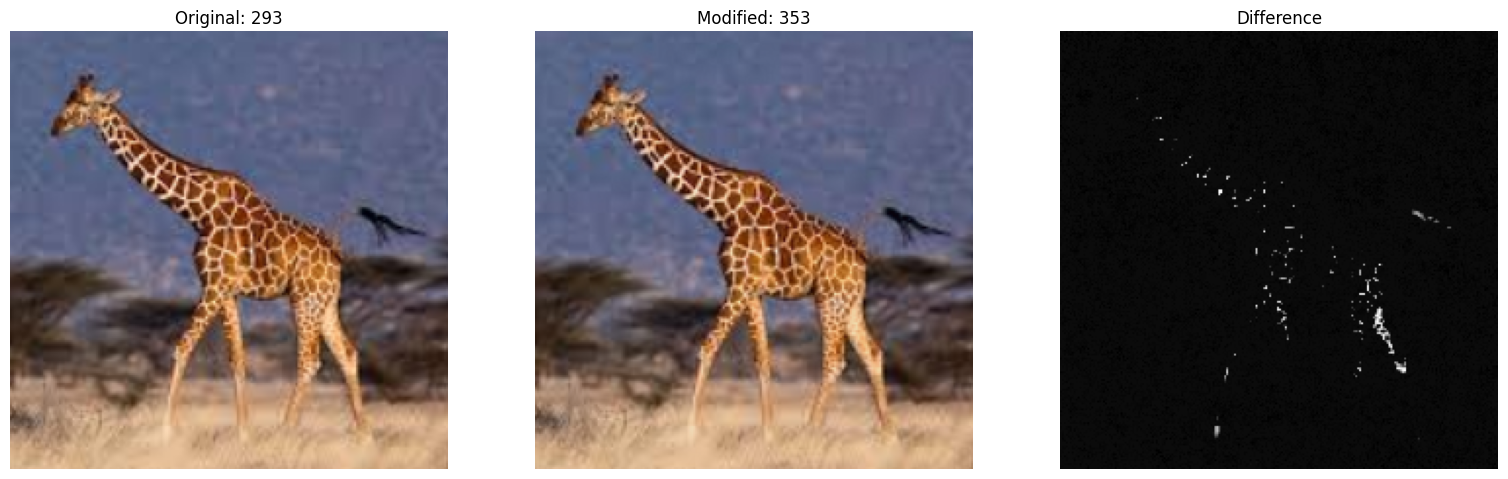

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models

def func(inp, net=None, target=None):
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss

def attack(tensor, net, eps=1e-3, n_iter=50):
    
    new_tensor = tensor.detach().clone()

    orig_prediction = net(tensor).argmax()
    print(f"Original prediction: {orig_prediction}")

    for i in range(n_iter):
        net.zero_grad()

        grad = compute_gradient(
                func, new_tensor, net=net, target=orig_prediction.item()
                )
        new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_prediction = net(new_tensor).argmax()

        if orig_prediction != new_prediction:
            print(f"We fooled the network after {i} iterations!")
            print(f"New prediction: {new_prediction.item()}")
            break

    return new_tensor, orig_prediction.item(), new_prediction.item()


if __name__ == "__main__":
    net = models.resnet18(pretrained=True)
    net.eval()

    tensor = read_image("images.jpeg")

    new_tensor, orig_prediction, new_prediction = attack(
            tensor, net, eps=1e-3, n_iter=100
            )
    # here the eps is for the learning rate and n_iter will continuously loop till the model is fooled

    _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
    arr = to_array(tensor)
    new_arr = to_array(new_tensor)
    diff_arr = np.abs(arr - new_arr).mean(axis=-1)
    diff_arr = diff_arr / diff_arr.max()

    ax_orig.imshow(arr)
    ax_new.imshow(new_arr)
    ax_diff.imshow(diff_arr, cmap="gray")

    ax_orig.axis("off")
    ax_new.axis("off")
    ax_diff.axis("off")

    ax_orig.set_title(f"Original: {orig_prediction}")
    ax_new.set_title(f"Modified: {new_prediction}")
    ax_diff.set_title("Difference")

    plt.savefig("res_1.png")